# Demonstration of musically informed metrics

In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from config import *
from helpers.analysis import *

warnings.filterwarnings("ignore")

figs_path = os.path.join(paper, 'figs')
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

## Information Retrieval (IR) metrics

In [2]:
# get the benchmark performance results
frame_res = pd.read_csv(os.path.join(results, 'IR_frame.csv'))
note_offset_res = pd.read_csv(os.path.join(results, 'IR_note_offset.csv'))
note_offset_velocity_res = pd.read_csv(os.path.join(results, 'IR_note_offset_velocity.csv'))

# exlude Batik results from analysis
frame_res = frame_res[frame_res['split'] != 'Batik']
note_offset_res = note_offset_res[note_offset_res['split'] != 'Batik']
note_offset_velocity_res = note_offset_velocity_res[note_offset_velocity_res['split'] != 'Batik']

In [3]:
# get mean frame fscore per model, split, and recording
frame_mean = frame_res.groupby(['model', 'split', 'recording'])[['f_f']].mean()
frame_mean = sort_index(frame_mean, 'model')
frame_mean = sort_index(frame_mean, 'split')
frame_mean = sort_index(frame_mean, 'recording')
frame_mean_values = frame_mean.values

# get mean note_offset fscore per model, split, and recording
note_offset_mean = note_offset_res.groupby(['model', 'split', 'recording'])[['f_no']].mean()
note_offset_mean = sort_index(note_offset_mean, 'model')
note_offset_mean = sort_index(note_offset_mean, 'split')
note_offset_mean = sort_index(note_offset_mean, 'recording')
note_offset_mean_values = note_offset_mean.values

# get mean note_offset_velocity fscore per model, split, and recording
note_offset_velocity_mean = note_offset_velocity_res.groupby(['model', 'split', 'recording'])[['f_nov']].mean()
note_offset_velocity_mean = sort_index(note_offset_velocity_mean, 'model')
note_offset_velocity_mean = sort_index(note_offset_velocity_mean, 'split')
note_offset_velocity_mean = sort_index(note_offset_velocity_mean, 'recording')
note_offset_velocity_mean_values = note_offset_velocity_mean.values

# combine them in one df
model_split_rec_res = frame_mean.index.to_frame(index=False)
model_split_rec_res['frame'] = frame_mean_values
model_split_rec_res['note_offset'] = note_offset_mean_values
model_split_rec_res['note_offset_velocity'] = note_offset_velocity_mean_values
model_split_rec_res

,model,split,recording,frame,note_offset,note_offset_velocity
0,oaf,train,maestro,0.880704,0.618337,0.592929
1,oaf,train,disklavier,0.818479,0.526871,0.485343
2,oaf,validation,maestro,0.840409,0.649218,0.623573
3,oaf,validation,disklavier,0.769609,0.553900,0.516136
4,oaf,test,maestro,0.852710,0.593150,0.569510
5,oaf,test,disklavier,0.804895,0.498850,0.460710
6,kong,train,maestro,0.920717,0.889925,0.875636
7,kong,train,disklavier,0.850774,0.738400,0.665978
8,kong,validation,maestro,0.893618,0.861709,0.847109
9,kong,validation,disklavier,0.867827,0.814155,0.747955


In [4]:
# Perform Krusal Wallis ANOVA to test:
# 1) if there is a significant difference in the f score per split?
# 2) if there is a significant difference in the f score per recording?
# 3) if there is a significant difference in the f score per recording AND split?

for model in ['oaf', 'kong', 'T5']:
    for metric_var, metric_res in zip(['frame', 'note_offset', 'note_offset_velocity'], [frame_res, note_offset_res, note_offset_velocity_res]):
        for split_var in ['split', 'recording']:#, ['split', 'recording']]:
            # for stats_metric in ['friedman', 'kruskal']:
            for stats_metric in ['kruskal']:
                # test_statistical_significance_benchmark(metric_var, results, model, split_var, stats_metric, exclude_batik=False)
                test_statistical_significance_benchmark(metric_var, metric_res, model, split_var, stats_metric)
            print()
    print()


Testing statistical difference of frame for model oaf across different splits using kruskal test
Model oaf (Kruskal=7.3366, p=0.0255) : p results across different splits are different
Model oaf (Kruskal=12.9790, p=0.0015) : r results across different splits are different
Model oaf (Kruskal=9.0649, p=0.0108) : f results across different splits are different

Testing statistical difference of frame for model oaf across different recordings using kruskal test
Model oaf (Kruskal=2.7044, p=0.1001) : p results across different recordings are the same 
Model oaf (Kruskal=84.0100, p=0.0000) : r results across different recordings are different
Model oaf (Kruskal=29.7675, p=0.0000) : f results across different recordings are different

Testing statistical difference of note_offset for model oaf across different splits using kruskal test
Model oaf (Kruskal=1.9694, p=0.3736) : p results across different splits are the same 
Model oaf (Kruskal=2.1247, p=0.3456) : r results across different splits 

## Musically informed metrics

In [5]:
# get the musical metrics results
timing = pd.read_csv(os.path.join(results, 'musical_timing.csv'))
articulation = pd.read_csv(os.path.join(results, 'musical_articulation.csv'))
harmony = pd.read_csv(os.path.join(results, 'musical_harmony.csv'))
dynamics = pd.read_csv(os.path.join(results, 'musical_dynamics.csv'))

# slice and combine them into one results df
timing_metrics = ['melody_ioi_corr', 'acc_ioi_corr',
                  'melody_ioi_dtw_dist', 'acc_ioi_dtw_dist', 'melody_ioi_hist_kld',
                  'acc_ioi_hist_kld']
articulation_metrics = ['melody_kor_corr_64', 'bass_kor_corr_64', 'ratio_kor_corr_64',
                        'melody_kor_corr_127', 'bass_kor_corr_127', 'ratio_kor_corr_127']
harmony_metrics = ['cd_corr', 'cm_corr', 'ts_corr']
dynamics_metrics = ['dyn_corr']

musical_res = timing.copy()
musical_res[articulation_metrics] = articulation[articulation_metrics]
musical_res[harmony_metrics] = harmony[harmony_metrics]
musical_res[dynamics_metrics] = dynamics[dynamics_metrics]

# exlude Batik results from analysis
musical_res = musical_res[musical_res['split'] != 'Batik']

#### Timing

In [6]:
# get grouped mean for timing
timing_mean_df = get_grouped_mean_results(musical_res, timing_metrics)
timing_mean_df_wide = long_to_wide(timing_mean_df, index_cols=[
                                   'split', 'recording'], column_var='model', value_var=timing_metrics, sort_cols=True)
timing_mean_df_wide

acc_ioi_corr                 acc_ioi_dtw_dist  \
model                          oaf    kong      T5              oaf   
split      recording                                                  
train      maestro          0.2347  0.3823  0.4350        3859.7083   
           disklavier       0.4057  0.2859  0.3006        4671.8889   
validation maestro          0.2135  0.3498  0.4899        2655.5455   
           disklavier       0.5415  0.3503  0.3668        2710.2727   
test       maestro          0.1544  0.3260  0.3939        3451.2500   
           disklavier       0.4098  0.2508  0.2534        4050.2000   

                                             acc_ioi_hist_kld                  \
model                       kong          T5              oaf    kong      T5   
split      recording                                                            
train      maestro     2050.4722   7844.2639           4.5408  0.1631  0.0863   
           disklavier  3694.3889  12436.6250           3.8761  0.7537  0.6738   
validation maestro     1553.1818   6039.3636           4.9044  0.1488  0.0726   
           disklavier  1977.2727   7498.0000           4.1321  0.7580  0.7030   
test       maestro     1981.4500   9103.9000           4.9453  0.1530  0.0773   
           disklavier  3000.2500  10401.2500           3.8640  0.8354  0.7751   

                      melody_ioi_corr                 melody_ioi_dtw_dist  \
model                             oaf    kong      T5                 oaf   
split      recording                                                        
train      maestro             0.2199  0.5353  0.2209           1674.3056   
           disklavier          0.4398  0.5614  0.2051           1761.5000   
validation maestro             0.3362  0.6320  0.1970            923.2727   
           disklavier          0.5276  0.6480  0.2409            941.3636   
test       maestro             0.2476  0.5478  0.2384           1113.5000   
           disklavier          0.4689  0.5661  0.2281           1119.6000   

                                            melody_ioi_hist_kld          \
model                       kong         T5                 oaf    kong   
split      recording                                                      
train      maestro      749.3194  2834.6944              1.6828  0.2644   
           disklavier  1274.3194  3869.9028              1.4974  0.8510   
validation maestro      500.1818  2263.3636              1.9677  0.2438   
           disklavier   680.1818  2296.1818              1.6628  0.8379   
test       maestro      698.2500  3226.3000              1.6381  0.4018   
           disklavier   945.9500  3250.7000              1.5717  1.4662   

                               
model                      T5  
split      recording           
train      maestro     0.3721  
           disklavier  1.3655  
validation maestro     0.3529  
           disklavier  1.2896  
test       maestro     0.6539  
           disklavier  2.1036

In [7]:
# Now let's test for statistical significance
for model in ['oaf', 'kong', 'T5']:
    for split_var in ['split', 'recording']:
        print(f'MODEL {model} with DIMENSION: {split_var}')
        test_statistical_significance(timing_metrics, musical_res, model, split_var)
        print()
    print()

MODEL oaf with DIMENSION: split
Testing statistical difference of ['melody_ioi_corr', 'acc_ioi_corr', 'melody_ioi_dtw_dist', 'acc_ioi_dtw_dist', 'melody_ioi_hist_kld', 'acc_ioi_hist_kld'] for model oaf across different splits using Kruskal-Wallis test
Model oaf (Kruskal=4.7508, p=0.0930) : melody_ioi_corr results across different splits are the same 
Model oaf (Kruskal=2.8176, p=0.2444) : acc_ioi_corr results across different splits are the same 
Model oaf (Kruskal=15.7656, p=0.0004) : melody_ioi_dtw_dist results across different splits are different
Model oaf (Kruskal=6.6777, p=0.0355) : acc_ioi_dtw_dist results across different splits are different
Model oaf (Kruskal=1.2723, p=0.5293) : melody_ioi_hist_kld results across different splits are the same 
Model oaf (Kruskal=1.3652, p=0.5053) : acc_ioi_hist_kld results across different splits are the same 

MODEL oaf with DIMENSION: recording
Testing statistical difference of ['melody_ioi_corr', 'acc_ioi_corr', 'melody_ioi_dtw_dist', 'acc

#### Articulation

In [8]:
# get grouped mean results for articulation
articulation_mean_df = get_grouped_mean_results(musical_res, articulation_metrics)
articulation_mean_df_wide = long_to_wide(articulation_mean_df, index_cols=[
                                            'split', 'recording'], column_var='model', value_var=articulation_metrics, sort_cols=True)
articulation_mean_df_wide

bass_kor_corr_127                 bass_kor_corr_64  \
model                               oaf    kong      T5              oaf   
split      recording                                                       
train      maestro               0.2878  0.5668  0.2990           0.2878   
           disklavier            0.1503  0.1490  0.0507           0.1503   
validation maestro               0.2336  0.5269  0.1900           0.2336   
           disklavier            0.1738  0.1786  0.0735           0.1738   
test       maestro               0.1941  0.4010  0.1953           0.1941   
           disklavier            0.1302  0.1930  0.0612           0.1302   

                                      melody_kor_corr_127                  \
model                    kong      T5                 oaf    kong      T5   
split      recording                                                        
train      maestro     0.7287  0.2990              0.4292  0.5270  0.3002   
           disklavier  0.2893  0.0507              0.2112  0.2274  0.1302   
validation maestro     0.6961  0.1900              0.3794  0.5142  0.2444   
           disklavier  0.2805  0.0735              0.1833  0.2150  0.0880   
test       maestro     0.5816  0.1953              0.3355  0.4606  0.2397   
           disklavier  0.2774  0.0612              0.1210  0.1475  0.0815   

                      melody_kor_corr_64                 ratio_kor_corr_127  \
model                                oaf    kong      T5                oaf   
split      recording                                                          
train      maestro                0.4292  0.7864  0.3002             0.4556   
           disklavier             0.2112  0.4169  0.1302             0.2294   
validation maestro                0.3794  0.6673  0.2444             0.3590   
           disklavier             0.1833  0.3157  0.0880             0.1316   
test       maestro                0.3355  0.6209  0.2397             0.3496   
           disklavier             0.1210  0.2688  0.0815             0.1082   

                                      ratio_kor_corr_64                  
model                    kong      T5               oaf    kong      T5  
split      recording                                                     
train      maestro     0.5717  0.3347            0.4556  0.7478  0.3347  
           disklavier  0.2289  0.1138            0.2294  0.3533  0.1138  
validation maestro     0.5460  0.2526            0.3590  0.5761  0.2526  
           disklavier  0.1275  0.0592            0.1316  0.1513  0.0592  
test       maestro     0.4363  0.2498            0.3496  0.5640  0.2498  
           disklavier  0.1131  0.0645            0.1082  0.1861  0.0645

In [9]:
# again test for statistical significance
for model in ['oaf', 'kong', 'T5']:
    for split_var in ['split', 'recording']:
        print(f'MODEL {model} with DIMENSION: {split_var}')
        test_statistical_significance(
            articulation_metrics, musical_res, model, split_var)
        print()
    print()

MODEL oaf with DIMENSION: split
Testing statistical difference of ['melody_kor_corr_64', 'bass_kor_corr_64', 'ratio_kor_corr_64', 'melody_kor_corr_127', 'bass_kor_corr_127', 'ratio_kor_corr_127'] for model oaf across different splits using Kruskal-Wallis test
Model oaf (Kruskal=10.5482, p=0.0051) : melody_kor_corr_64 results across different splits are different
Model oaf (Kruskal=5.0374, p=0.0806) : bass_kor_corr_64 results across different splits are the same 
Model oaf (Kruskal=18.5681, p=0.0001) : ratio_kor_corr_64 results across different splits are different
Model oaf (Kruskal=10.5482, p=0.0051) : melody_kor_corr_127 results across different splits are different
Model oaf (Kruskal=5.0374, p=0.0806) : bass_kor_corr_127 results across different splits are the same 
Model oaf (Kruskal=18.5681, p=0.0001) : ratio_kor_corr_127 results across different splits are different

MODEL oaf with DIMENSION: recording
Testing statistical difference of ['melody_kor_corr_64', 'bass_kor_corr_64', '

#### Harmony

In [10]:
# get grouped mean results for harmony
harmony_mean_df = get_grouped_mean_results(musical_res, harmony_metrics)
harmony_mean_df

harmony_mean_df_wide = long_to_wide(
    harmony_mean_df, index_cols=['split', 'recording'], column_var='model',
    value_var=harmony_metrics, sort_cols=True)
harmony_mean_df_wide

cd_corr                 cm_corr                 ts_corr  \
model                     oaf    kong      T5     oaf    kong      T5     oaf   
split      recording                                                            
train      maestro     0.7550  0.8427  0.7785  0.2437  0.2298  0.1678  0.0843   
           disklavier  0.8602  0.8652  0.7301  0.1835  0.1921  0.1702  0.1275   
validation maestro     0.6846  0.8441  0.6886  0.2036  0.1528  0.1174  0.2420   
           disklavier  0.7925  0.8640  0.6945  0.1454  0.1409  0.0974  0.2709   
test       maestro     0.6343  0.7771  0.6665  0.2781  0.2477  0.1918 -0.0035   
           disklavier  0.8265  0.8459  0.7044  0.2500  0.2383  0.1529  0.0076   

                                       
model                    kong      T5  
split      recording                   
train      maestro     0.1123  0.0894  
           disklavier  0.1147  0.0839  
validation maestro     0.1840  0.1844  
           disklavier  0.2137  0.1411  
test       maestro    -0.0343  0.0411  
           disklavier -0.0290  0.0196

In [11]:
# again test for statistical significance
for model in ['oaf', 'kong', 'T5']:
    for split_var in ['split', 'recording']:
        print(f'MODEL {model} with DIMENSION: {split_var}')
        test_statistical_significance(
            harmony_metrics, musical_res, model, split_var)
        print()
    print()

MODEL oaf with DIMENSION: split
Testing statistical difference of ['cd_corr', 'cm_corr', 'ts_corr'] for model oaf across different splits using Kruskal-Wallis test
Model oaf (Kruskal=19.9067, p=0.0000) : cd_corr results across different splits are different
Model oaf (Kruskal=7.4837, p=0.0237) : cm_corr results across different splits are different
Model oaf (Kruskal=18.4889, p=0.0001) : ts_corr results across different splits are different

MODEL oaf with DIMENSION: recording
Testing statistical difference of ['cd_corr', 'cm_corr', 'ts_corr'] for model oaf across different recordings using Kruskal-Wallis test
Model oaf (Kruskal=83.7958, p=0.0000) : cd_corr results across different recordings are different
Model oaf (Kruskal=6.8545, p=0.0088) : cm_corr results across different recordings are different
Model oaf (Kruskal=0.7849, p=0.3756) : ts_corr results across different recordings are the same 


MODEL kong with DIMENSION: split
Testing statistical difference of ['cd_corr', 'cm_corr'

#### Dynamics

In [12]:
# get grouped mean results for dynamics
dynamics_mean_df = get_grouped_mean_results(musical_res, dynamics_metrics)
dynamics_mean_df_wide = long_to_wide(dynamics_mean_df, index_cols=[
                                        'split', 'recording'], column_var='model', value_var=dynamics_metrics, sort_cols=True)      
dynamics_mean_df_wide

dyn_corr                
model                      oaf    kong      T5
split      recording                          
train      maestro      0.5985  0.6935  0.6847
           disklavier   0.3355  0.3586  0.2855
validation maestro      0.4468  0.5531  0.5235
           disklavier   0.1166  0.1494  0.1561
test       maestro      0.4325  0.5481  0.5201
           disklavier   0.1380  0.1615  0.1357

In [13]:
# again test for statistical significance
for model in ['oaf', 'kong', 'T5']:
    for split_var in ['split', 'recording']:
        print(f'MODEL {model} with DIMENSION: {split_var}')
        test_statistical_significance(
            dynamics_metrics, musical_res, model, split_var)
        print()
    print()

MODEL oaf with DIMENSION: split
Testing statistical difference of ['dyn_corr'] for model oaf across different splits using Kruskal-Wallis test
Model oaf (Kruskal=25.1936, p=0.0000) : dyn_corr results across different splits are different

MODEL oaf with DIMENSION: recording
Testing statistical difference of ['dyn_corr'] for model oaf across different recordings using Kruskal-Wallis test
Model oaf (Kruskal=63.5585, p=0.0000) : dyn_corr results across different recordings are different


MODEL kong with DIMENSION: split
Testing statistical difference of ['dyn_corr'] for model kong across different splits using Kruskal-Wallis test
Model kong (Kruskal=20.5686, p=0.0000) : dyn_corr results across different splits are different

MODEL kong with DIMENSION: recording
Testing statistical difference of ['dyn_corr'] for model kong across different recordings using Kruskal-Wallis test
Model kong (Kruskal=96.9884, p=0.0000) : dyn_corr results across different recordings are different


MODEL T5 wit

### Let's have a look at another alternative (perceptually informed) metric: PEAMT

In [14]:
peamt = pd.read_csv(os.path.join(results, 'peamt.csv'))
peamt = peamt[peamt['split'] != 'Batik']

peamt_mean_df = get_grouped_mean_results(peamt, ['peamt'])
peamt_mean_df_wide = long_to_wide(peamt_mean_df, index_cols=['split', 'recording'], column_var='model', value_var=['peamt'], sort_cols=True)

peamt_mean_df_wide

peamt                
model                     oaf    kong      T5
split      recording                         
train      maestro     0.6617  0.6284  0.5880
           disklavier  0.0397  0.0316  0.0276
validation maestro     0.6475  0.5934  0.5339
           disklavier  0.0193  0.0158  0.0138
test       maestro     0.6454  0.6252  0.5707
           disklavier  0.0268  0.0215  0.0185

In [15]:
# again test for statistical significance
for model in ['oaf', 'kong', 'T5']:
    for split_var in ['split', 'recording']:
        print(f'MODEL {model} with DIMENSION: {split_var}')
        test_statistical_significance(
            ['peamt'], peamt, model, split_var)
        print()
    print()

MODEL oaf with DIMENSION: split
Testing statistical difference of ['peamt'] for model oaf across different splits using Kruskal-Wallis test
Model oaf (Kruskal=2.2334, p=0.3274) : peamt results across different splits are the same 

MODEL oaf with DIMENSION: recording
Testing statistical difference of ['peamt'] for model oaf across different recordings using Kruskal-Wallis test
Model oaf (Kruskal=153.6972, p=0.0000) : peamt results across different recordings are different


MODEL kong with DIMENSION: split
Testing statistical difference of ['peamt'] for model kong across different splits using Kruskal-Wallis test
Model kong (Kruskal=2.3469, p=0.3093) : peamt results across different splits are the same 

MODEL kong with DIMENSION: recording
Testing statistical difference of ['peamt'] for model kong across different recordings using Kruskal-Wallis test
Model kong (Kruskal=153.6978, p=0.0000) : peamt results across different recordings are different


MODEL T5 with DIMENSION: split
Testi

## Comparison IR with musically informed metrics

In [16]:
# combine all metrics results
ALL_RESULTS = frame_res.copy()
# get f1 scores for frame, note-with-offset and note-with-offset-velocity metrics
ALL_RESULTS.drop(columns=['p_f', 'r_f'], inplace=True)
ALL_RESULTS['f_no'] = note_offset_res['f_no']
ALL_RESULTS['f_nov'] = note_offset_velocity_res['f_nov']
# get musically informed metrics
ALL_RESULTS[timing_metrics[:2]] = timing[timing_metrics[:2]]
ALL_RESULTS[articulation_metrics[:3]] = articulation[articulation_metrics[:3]]
# rename articulation metrics columns
ALL_RESULTS.rename(columns={'melody_kor_corr_64': 'melody_kor_corr',
                            'bass_kor_corr_64': 'bass_kor_corr',
                            'ratio_kor_corr_64': 'ratio_kor_corr'}, inplace=True)
ALL_RESULTS[harmony_metrics] = harmony[harmony_metrics]
ALL_RESULTS[dynamics_metrics] = dynamics[dynamics_metrics]
# get perceptually informed PEAMT metric
ALL_RESULTS['peamt'] = peamt['peamt']

# overview of compared metrics
metrics_compared = ALL_RESULTS.columns[6:]

In [17]:
# add an epoch column : can we observe a difference in the performance of the models based on the epoch of the composer?
EPOCH_COMPOSER_MAPPING = {
    'baroque': ['Bach'],
    'classical': ['Haydn', 'Mozart', 'Beethoven'],
    'romantic': ['Schubert', 'Chopin', 'Liszt', 'Glinka'],
    '20th': ['Debussy', 'Scriabin', 'Rachmaninoff']
}
def map_composer_to_epoch(composer, epoch_composer_groups):
    for epoch, composers in epoch_composer_groups.items():
        if composer in composers:
            return epoch
    return None 

ALL_RESULTS['epoch'] = ALL_RESULTS['composer'].map(lambda x: map_composer_to_epoch(x, EPOCH_COMPOSER_MAPPING))

# groupby epoch
epoch_mean = ALL_RESULTS.groupby(['epoch', 'model', 'split', 'recording'])[metrics_compared].mean().round(4)
epoch_mean = sort_index(epoch_mean, 'epoch')
epoch_mean = sort_index(epoch_mean, 'model')
epoch_mean = sort_index(epoch_mean, 'split')
epoch_mean = sort_index(epoch_mean, 'recording')
# combine into one df
epoch_mean_df = epoch_mean.index.to_frame(index=False)
epoch_mean_df[metrics_compared] = epoch_mean.values
epoch_mean_df


,epoch,model,split,recording,f_f,f_no,f_nov,melody_ioi_corr,acc_ioi_corr,melody_kor_corr,bass_kor_corr,ratio_kor_corr,cd_corr,cm_corr,ts_corr,dyn_corr,peamt
0,baroque,oaf,train,maestro,0.8392,0.8217,0.8064,0.1103,0.0730,0.6245,0.5994,0.6793,0.6278,0.2560,0.3228,0.7830,0.8208
1,baroque,oaf,train,disklavier,0.8204,0.7033,0.6708,0.4186,-0.0913,0.1172,0.3254,0.2815,0.8315,0.1853,0.6387,0.4644,0.0345
2,baroque,kong,train,maestro,0.9231,0.9600,0.9562,0.4537,0.2028,0.7177,0.8131,0.7705,0.9098,0.2288,0.6388,0.8145,0.8105
3,baroque,kong,train,disklavier,0.9072,0.9430,0.8917,0.3586,-0.0658,0.1199,0.3356,0.2952,0.8377,0.1952,0.6351,0.5065,0.0250
4,baroque,T5,train,maestro,0.2108,0.0705,0.0605,0.1420,0.1122,0.2022,0.4335,0.2739,0.6596,0.0862,0.3523,0.8675,0.7604
5,baroque,T5,train,disklavier,0.6842,0.8267,0.7729,0.1341,-0.0148,0.0111,0.0985,0.0963,0.8322,0.1282,0.4329,0.3674,0.0252
6,classical,oaf,train,maestro,0.8665,0.7250,0.6986,0.3533,0.2940,0.3351,0.2744,0.4076,0.7745,0.3204,0.1671,0.7144,0.6348
7,classical,oaf,train,disklavier,0.7937,0.6011,0.5543,0.5391,0.5978,0.1874,0.0994,0.1929,0.8689,0.2568,0.1593,0.5509,0.0269
8,classical,oaf,validation,maestro,0.8334,0.6510,0.6238,0.3099,0.1868,0.3755,0.2449,0.3856,0.6930,0.2106,0.1956,0.4590,0.6608
9,classical,oaf,validation,disklavier,0.7497,0.5353,0.4989,0.5090,0.5208,0.1697,0.1566,0.1373,0.8157,0.1507,0.2247,0.1250,0.0142


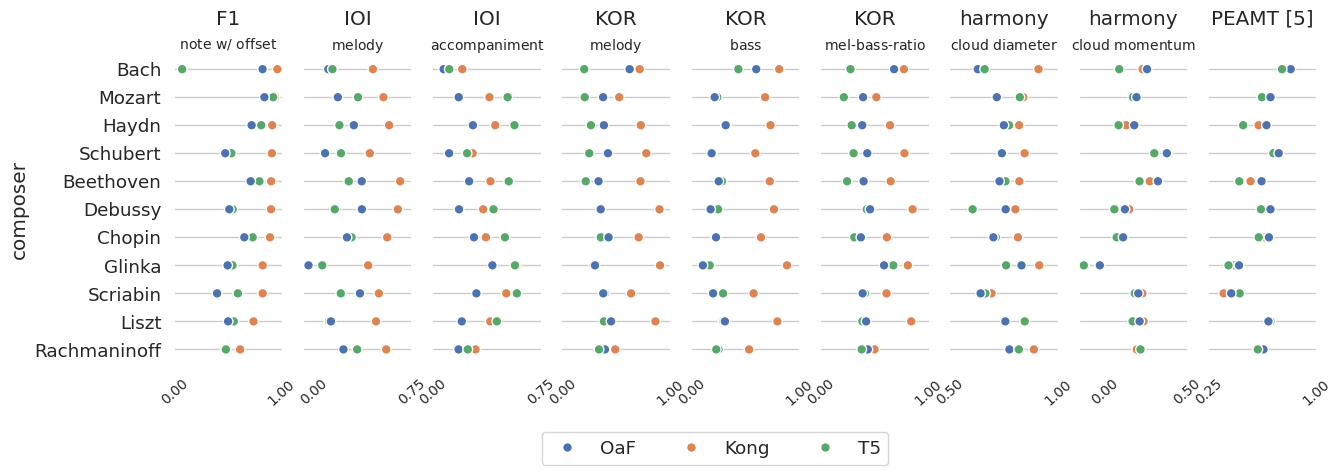

In [18]:
# Can we observe differences in metrics results based on the composer?
# For the following, we compare note-with-offset F1 with all other metrics except for dynamics

# plot the f-no scores against musical metrics (all but dynamics)
import numpy as np
import math
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

# helpers for axes ticks
def ceil_to_closest(number):
    # Divide the number by 0.25
    divided = number / 0.25
    # Ceil the result
    ceiled = math.ceil(divided)
    # Multiply back by 0.25
    result = ceiled * 0.25
    return result


def floor_to_closest(number):
    # Divide the number by 0.25
    divided = number / 0.25
    # Floor the result
    floored = math.floor(divided)
    # Multiply back by 0.25
    result = floored * 0.25
    return result


# set style
sns.set_theme(font='Arial', font_scale=1.2)
sns.set_style("whitegrid")

# choose metrics to compare
metrics_compared_plot = ['f_no', 'melody_ioi_corr', 'acc_ioi_corr',
                         'melody_kor_corr', 'bass_kor_corr', 'ratio_kor_corr', 'cd_corr', 'cm_corr', 'peamt']

results_excerpts = ALL_RESULTS[['composer',
                                'model', 'recording'] + metrics_compared_plot]
# filter to get only maestro recordings
results_excerpts = results_excerpts[results_excerpts['recording'] == 'maestro']

# get composer mean per model
composer_mean = results_excerpts.groupby(['composer', 'model'])[
    metrics_compared_plot].mean()
composer_mean_df = composer_mean.index.to_frame(index=False)
composer_mean_df[metrics_compared_plot] = composer_mean.values

# pairgrid
g = sns.PairGrid(composer_mean_df.sort_values("f_no", ascending=False),
                 hue='model', hue_order=['oaf', 'kong', 'T5'],
                 x_vars=composer_mean_df.columns[2:],
                 y_vars=['composer'],
                 height=4, aspect=.35)

# draw a dot plot using the stripplot function
g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")
# use same x axis limits on all columns and add better labels
g.set(xlabel="", ylabel="composer")
g.axes.flat[0].legend(loc='upper left', bbox_to_anchor=(-1.5, 1.0))

col2title = {'f_no': 'F1\n' + r'$_{\text{note w/ offset}}$',
             'melody_ioi_corr': 'IOI\n' + r'$_{\text{melody}}$',  # timing
             'acc_ioi_corr': 'IOI\n' + r'$_{\text{accompaniment}}$',  # timing
             # articulation
             'melody_kor_corr': 'KOR\n' + r'$_{\text{melody}}$',
             'bass_kor_corr': 'KOR\n' + r'$_{\text{bass}}$',  # articulation
             # articulation
             'ratio_kor_corr': 'KOR\n' + r'$_{\text{mel-bass-ratio}}$',
             'cd_corr': 'harmony\n' + r'$_{\text{cloud diameter}}$',  # harmony
             'cm_corr': 'harmony\n' + r'$_{\text{cloud momentum}}$',  # harmony
             'ts_corr': 'tensile\nstrain',  # harmony
             'peamt': 'PEAMT [5]\n'  # PEAMT
             }

for ax, col in zip(g.axes.flat, metrics_compared_plot):
    # Set a different title for each axes
    ax.set(title=col2title[col])
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    # ax.setrotation=0, fontsize=8
    ax.tick_params(axis='x', labelsize=10)
    ax.legend([], [], frameon=False)

    col_min, col_max = ax.get_xlim()
    spec_min = np.max([0, floor_to_closest(col_min)])
    spec_max = np.min([ceil_to_closest(col_max), 1])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xticks([spec_min, spec_max])
    ax.tick_params(axis='x', labelrotation=42)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=['OaF', 'Kong', 'T5'], bbox_to_anchor=[
             0.5, -0.1], loc='lower center', ncol=3)

sns.despine(left=True, bottom=True)
plt.subplots_adjust(hspace=0.6)
plt.savefig(os.path.join(
    figs_path, 'fig1_model_metrics_comparison_MAESTRO_subset.pdf'))
plt.show()

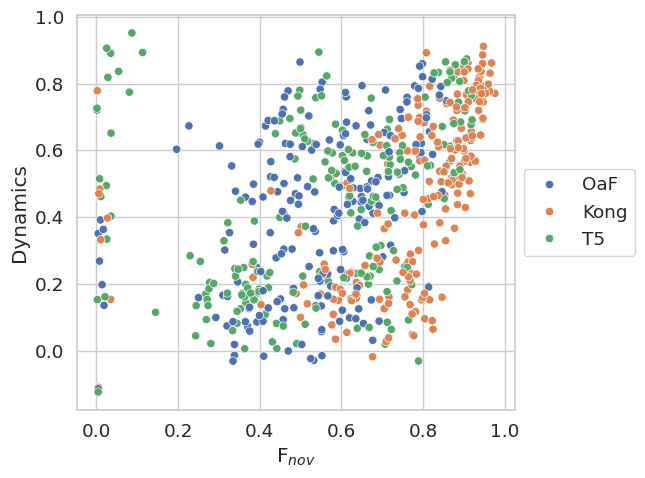

In [19]:
# now let's compare our dynamics metric with note-with-offset-velocity F1 score
fig, axs = plt.subplots(1, figsize=(6, 5))
fig.tight_layout()
fig.subplots_adjust(top=0.9)

# handles, labels = axs[0].get_legend_handles_labels()
sns.scatterplot(data=ALL_RESULTS, x='f_nov', y='dyn_corr', hue='model', hue_order=[
                'oaf', 'kong', 'T5']) 
plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.ylabel('Dynamics')
plt.xlabel('F'+r'$_{nov}$')
legend = plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)

# Update legend labels
new_labels = ['OaF', 'Kong', 'T5']
for text, label in zip(legend.get_texts(), new_labels):
    text.set_text(label)

plt.savefig(os.path.join(figs_path, f'fig2_dynamics_vs_note_offset_velocity.pdf'), dpi=300, bbox_inches = "tight")
# plt.show()


## Comparison IR with musically informed metrics on perturbed audio

In [20]:
# get the information retrieval metrics results on the perturbed data
revnoise_ir_f = pd.read_csv(os.path.join(results, 'revnoise_IR_frame.csv'))
revnoise_ir_no = pd.read_csv(os.path.join(
    results, 'revnoise_IR_note_offset.csv'))
revnoise_ir_nov = pd.read_csv(os.path.join(
    results, 'revnoise_IR_note_offset_velocity.csv'))

# get the musically informed metrics
revnoise_mi_timing = pd.read_csv(os.path.join(
    results, 'revnoise_musical_timing.csv'))
revnoise_mi_articulation = pd.read_csv(os.path.join(
    results, 'revnoise_musical_articulation.csv'))
revnoise_mi_harmony = pd.read_csv(os.path.join(
    results, 'revnoise_musical_harmony.csv'))
revnoise_mi_dynamics = pd.read_csv(os.path.join(
    results, 'revnoise_musical_dynamics.csv'))

# slice and combine them into one results df
timing_metrics = ['melody_ioi_corr', 'acc_ioi_corr',
                  'melody_ioi_dtw_dist', 'acc_ioi_dtw_dist', 'melody_ioi_hist_kld',
                  'acc_ioi_hist_kld']
articulation_metrics = ['melody_kor_corr_64', 'bass_kor_corr_64', 'ratio_kor_corr_64',
                        'melody_kor_corr_127', 'bass_kor_corr_127', 'ratio_kor_corr_127']
harmony_metrics = ['cd_corr', 'cm_corr', 'ts_corr']
dynamics_metrics = ['dyn_corr']

# combine them into one results df
res_perturbed = revnoise_ir_no.copy()
# we drop the title, and split columns, as well as the p_no and r_no columns
res_perturbed.drop(columns=['title', 'split', 'p_no', 'r_no'], inplace=True)
# reorder the columns
res_perturbed = res_perturbed[['composer', 'model', 'recording', 'reverb', 'snr', 'f_no']]
res_perturbed['f_nov'] = revnoise_ir_nov['f_nov']
# get the musical metrics
res_perturbed[timing_metrics[:2]] = revnoise_mi_timing[timing_metrics[:2]]
res_perturbed[articulation_metrics[:3]] = revnoise_mi_articulation[articulation_metrics[:3]]
res_perturbed.rename(columns={'melody_kor_corr_64': 'melody_kor_corr',
                                'bass_kor_corr_64': 'bass_kor_corr',
                                'ratio_kor_corr_64': 'ratio_kor_corr'}, inplace=True)
res_perturbed[harmony_metrics] = revnoise_mi_harmony[harmony_metrics]
res_perturbed[dynamics_metrics] = revnoise_mi_dynamics[dynamics_metrics]
# exclude batik
res_perturbed = res_perturbed[res_perturbed['recording'] != 'batik_audio']

In [21]:
# lets look at the mean results per model, reverb and snr level
metrics_compared = res_perturbed.columns[5:]
res_perturbed.groupby(['model', 'reverb', 'snr'])[
    metrics_compared].mean().reset_index()

,model,reverb,snr,f_no,f_nov,melody_ioi_corr,acc_ioi_corr,melody_kor_corr,bass_kor_corr,ratio_kor_corr,cd_corr,cm_corr,ts_corr,dyn_corr
0,T5,l,12,0.000860,0.000580,-0.153600,0.018920,-0.017180,-0.008540,-0.010675,0.134660,-0.026480,0.002660,0.099580
1,T5,l,24,0.016533,0.009633,0.063400,0.060050,-0.002900,0.023617,0.014267,0.185767,0.168817,0.146983,-0.108017
2,T5,l,6,0.000475,0.000325,-0.100950,0.189425,-0.028525,0.015250,-0.023950,0.257725,-0.200700,0.007275,0.013075
3,T5,l,nonoise,0.063433,0.055000,-0.042633,0.095600,0.005117,0.019650,-0.020933,0.320250,0.107700,0.165817,0.071917
4,T5,m,12,0.001200,0.000700,0.050017,-0.046583,-0.039717,0.037000,-0.031233,0.068167,0.119917,0.009683,-0.040150
5,T5,m,24,0.048967,0.033367,0.082583,0.090817,-0.010833,0.004017,-0.000217,0.316050,0.134667,0.049467,0.011600
6,T5,m,6,0.000900,0.000800,-0.092500,-0.040120,0.011540,0.013820,0.015460,0.027560,0.044420,-0.130360,-0.049220
7,T5,m,nonoise,0.132717,0.117083,0.062750,0.187083,0.028250,0.022667,0.043317,0.432067,0.187017,0.179750,0.095950
8,T5,norev,12,0.088050,0.049017,0.135000,0.113300,0.018750,0.064167,0.032767,0.292900,0.161417,0.116167,0.011533
9,T5,norev,24,0.403467,0.371383,0.094533,0.270400,0.072967,0.090483,0.118517,0.611000,0.181300,0.072733,0.338683


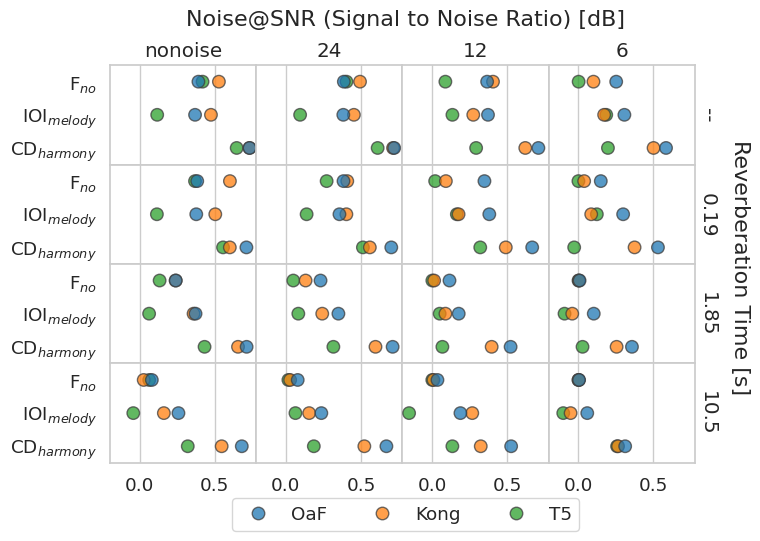

In [22]:
# let's plot some metrics

metrics_plot = ['f_no', 'melody_ioi_corr', 'cd_corr']
# prep data for plotting
mean_res_perturbed = res_perturbed.groupby(['model', 'reverb', 'snr'])[
    metrics_plot].mean().reset_index()
mean_res_perturbed_melt = mean_res_perturbed.melt(
    id_vars=['model', 'reverb', 'snr'], value_vars=metrics_plot, var_name='metric', value_name='value')

hue_order = ['oaf', 'kong', 'T5']
row_order = ['norev', 's', 'm', 'l']
col_order = ['nonoise', '24', '12', '6']


g = sns.FacetGrid(mean_res_perturbed_melt.rename(columns={'snr': 'N', 'reverb': 'R'}),
                  col='N',  row='R', row_order=row_order, col_order=col_order,
                  height=1.3, aspect=1.6, margin_titles=True, despine=False)
g.map_dataframe(sns.stripplot, x='value', y='metric', hue='model', hue_order=hue_order, palette='tab10',
                orient='h', alpha=.75, jitter=False, linewidth=1, size=9)

ol_names = ['--', '24', '12', '6']
g.row_names = ['--', '0.19', '1.85', '10.5']
g.set_titles(col_template='{col_name}', row_template='{row_name}')

g.figure.subplots_adjust(wspace=0, hspace=0)
g.set_axis_labels('', '')
g.set_yticklabels(['F'+r'$_{no}$', 'IOI'+r'$_{melody}$', 'CD'+r'$_{harmony}$'])

# Overall X Label
g.fig.text(x=0.6, y=.99,
           horizontalalignment='center',  # make sure it's aligned at center horizontally
           # this is the text in the xlabel
           s='Noise@SNR (Signal to Noise Ratio) [dB]',
           size=16)

# Overall Y Label
g.fig.text(x=0.99, y=0.525,
           verticalalignment='center',  # make sure it's aligned at center vertically
           s='Reverberation Time [s]',  # this is the text in the ylabel
           size=16,  # customize the fontsize if you will
           rotation=270)  # vertical text

# LEGEND below the plot
# g.add_legend()
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=['OaF', 'Kong', 'T5'], bbox_to_anchor=[
             0.6, 0.0], loc='lower center', ncol=3)


plt.savefig(os.path.join(figs_path, 'fig3_perturbed_metrics.pdf'), bbox_inches='tight')
